### INTRODUCTION: 

The visualization for this notebook uses Lonboard, which is a new Python library for fast, interactive geospatial vector data visualization for big raster or vector files in Jupyter. By utilizing new tools like GeoArrow and GeoParquet in conjunction with GPU-based map rendering, lonboard aims to enable visualizing large geospatial datasets interactively through a simple interface. 

CODE PREPARED BY:

*-- Paromita Basak, University of Maryland College Park*

CODE SUPPORTED BY: 

*-- Dr. Rajat Shinde, NASA IMPACT*

*-- Dr. Alex I. Mandel, Development Seed*

*-- Dr. Neha Hunka, University of Maryland College Park*

*-- Dr. Laura Duncanson, University of Maryland College Park

**Support via a GEDI Science Team grant, PI Dr. Laura Duncanson, and the NASA MAAP User Working Group**

In [1]:
#load packages to run scripts
import geopandas as gpd
from lonboard import viz
import matplotlib as mpl
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from lonboard import Map, BitmapLayer, BitmapTileLayer, PointCloudLayer, PolygonLayer, ScatterplotLayer
from lonboard.colormap import apply_continuous_cmap
import json
from palettable.colorbrewer.sequential import YlGnBu_7, Greens_3
from palettable.colorbrewer.diverging import Spectral_9
from matplotlib.colors import Normalize
import httpx

## Part 1: Explore GEDI Data over Cambodia
A clipped and quality-filtered version of GEDI's footprint-level height and biomass products have been prepared for this workshop. You can explore these datasets interactively below.

The NASA GEDI L4A data offers predictions of aboveground biomass density (AGBD in Mg/ha) and provides uncertainty estimates for each sampled geolocated laser footprint. The footprints are located within the global latitude band observed by the International Space Station (ISS), nominally between 51.6 degrees N and S, and cover the period from April 18, 2019, to March 16, 2023.

This section's code reads and visualizes a sample of the GEDI L4A shots in entire country of Cambodia using libraries such as geopandas, pyogrio and lonboard. This only shows 10% of the available data, sampling was done to allow visualization of the whole country. For actual applications, 10 times more data than is shown here is available.

In [2]:
path = "/projects/shared-buckets/leitoldv/gedi_subsetting_CAMBODIA/DATA/KHM_L4A.gpkg"

In [3]:
gedi_gdf = gpd.read_file(path, engine="pyogrio")

In [4]:
# Dropping columns which are not required
gedi_gdf = gedi_gdf.drop(columns=["shot_number", "filename", "lon_lowestmode", "lat_lowestmode", "agbd_t", "agbd_t_se", "geolocation/sensitivity_a2"])


In [5]:
#round variables as desired
gedi_gdf = gedi_gdf.round({"sensitivity":3, "elev_lowestmode":2, "agbd":2, "agbd_se":2}) 

In [11]:
# Sampling points at a interval of 10 to reduce the number of points for visualization
gedi_gdf_sampled = gedi_gdf#.iloc[::10]


In [87]:
#Deleye full file
#del gedi_gdf


In [25]:
GEDI_original_layer = ScatterplotLayer.from_geopandas(gedi_gdf_sampled)
m = Map(layers=[GEDI_original_layer])

In [26]:
m

Map(layers=[ScatterplotLayer(table=pyarrow.Table
sensitivity: float
elev_lowestmode: float
agbd: float
agbd_se…

In [27]:
GEDI_original_layer.get_fill_color = [200, 100, 100]

In [10]:
gedi_gdf.head()

,sensitivity,elev_lowestmode,agbd,agbd_se,geometry
0,0.954,91.61,71.34,17.13,POINT (102.48686 12.6615)
1,0.957,87.98,107.75,17.12,POINT (102.49031 12.66606)
2,0.950,132.17,38.49,17.13,POINT (102.49156 12.66771)
3,0.953,139.22,36.77,17.14,POINT (102.49187 12.66813)
4,0.976,130.69,83.52,17.12,POINT (102.49219 12.66855)


In [28]:
q10 = gedi_gdf_sampled['agbd'].quantile(.1)
q90 = gedi_gdf_sampled['agbd'].quantile(.9)

In [29]:
normalizer = mpl.colors.Normalize(q10, q90)

In [30]:
normalized_agbd = normalizer(gedi_gdf_sampled['agbd'])
normalized_agbd

masked_array(data=[0.34952844, 0.55764504, 0.1617605 , ..., 3.65310089,
                   0.70002858, 3.28465276],
             mask=False,
       fill_value=1e+20)

In [31]:
viridis_colormap = mpl.colormaps["viridis"]
GEDI_original_layer.get_fill_color = viridis_colormap(normalized_agbd, bytes=True)
GEDI_original_layer.radius_min_pixels = 1

In [32]:
ESRI_basemap = BitmapTileLayer(
    data="https://services.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}",
    tile_size=256,
    max_requests=-1,
    min_zoom=0,
    max_zoom=19,
)


In [33]:
m = Map(layers=[ESRI_basemap, GEDI_original_layer])
m

Map(layers=[BitmapTileLayer(data='https://services.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServ…

## Explore GEDI's Updated (provisional) version 2 biomass product
A new GEDI biomass model has been created for Broadleaf Trees in Asia (still not finalized, this is a first look!). You can explore this draft product below - there may be some changes before it is released (coming out in Fall, 2024). 

To explore this new dataset, and GEDI's full sampling, we have created a subset of the new data over Mondulkiri Srepok National Park. 

In this layer, you can see the GEDI heights (Relative Height metrics, RH) where RH_98 is maximum height and RH_50 is similar to mean height for each GEDI shot. The original biomass is agbd (aboveground biomass density) and the new draft biomass is AGBD_1.


In [34]:
path = "/projects/shared-buckets/pbasak/Cambodia_Notebook/NPAs_L4A_improved.gpkg"

In [35]:
Improved_GEDI_gdf = gpd.read_file(path, engine="pyogrio")


In [36]:
# Dropping columns which are not required
Improved_GEDI_gdf = Improved_GEDI_gdf.drop(columns=["shot_number", "field_1", "lon_lowestmode", "lat_lowestmode", "RH_10", "RH_20", "RH_30", "RH_40", "RH_60", "RH_70", "RH_80", "RH_90", "elev_lowestmode"])


In [37]:
Improved_GEDI_gdf.head()

,agbd,agbd_se,pft_class,quality_flag,RH_50,RH_98,AGBD_1,SE,geometry
0,78.833908,17.126760,4,True,8.98,14.75,137.629956,0.013677,POINT (107.30054 13.11133)
1,70.126076,17.126957,4,True,7.94,14.00,128.454579,0.013677,POINT (107.30369 13.11547)
2,93.679848,17.124052,4,True,9.81,17.41,149.549231,0.013677,POINT (107.31502 13.13041)
3,37.338348,17.131277,2,True,4.12,9.28,93.688718,0.013677,POINT (107.37511 13.20951)
4,56.163986,17.126404,4,True,3.48,17.49,104.089177,0.013677,POINT (107.38866 13.2273)


In [38]:
Improved_GEDI_layer = ScatterplotLayer.from_geopandas(Improved_GEDI_gdf)
m3 = Map(layers=[ESRI_basemap, Improved_GEDI_layer])
m3

Map(layers=[BitmapTileLayer(data='https://services.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServ…

In [39]:
q10 = Improved_GEDI_gdf['AGBD_1'].quantile(.1)
q90 = Improved_GEDI_gdf['AGBD_1'].quantile(.9)

In [40]:
normalizer = mpl.colors.Normalize(q10, q90)

In [41]:
normalized_agbd = normalizer(Improved_GEDI_gdf['AGBD_1'])
normalized_agbd

masked_array(data=[0.35473199, 0.30362479, 0.42112281, ..., 1.10945583,
                   0.91273102, 0.31932507],
             mask=False,
       fill_value=1e+20)

In [42]:
# Ensure lengths match
if len(normalized_agbd) == len(Improved_GEDI_gdf):
    # Apply the viridis colormap
    viridis_colormap = plt.get_cmap("viridis")
    colors = viridis_colormap(normalized_agbd, bytes=True)
    Improved_GEDI_layer.get_fill_color = colors
    Improved_GEDI_layer.radius_min_pixels = 5
else:
    raise ValueError("normalized_agbd length does not match the length of Improved_gedi_gdf")

## Compare the Original and New GEDI layers

In [121]:
m = Map(layers=[ESRI_basemap, GEDI_original_layer, Improved_GEDI_layer], basemap_style= Voyager)
m

Map(basemap_style='https://basemaps.cartocdn.com/gl/voyager-gl-style/style.json', layers=[BitmapTileLayer(data…

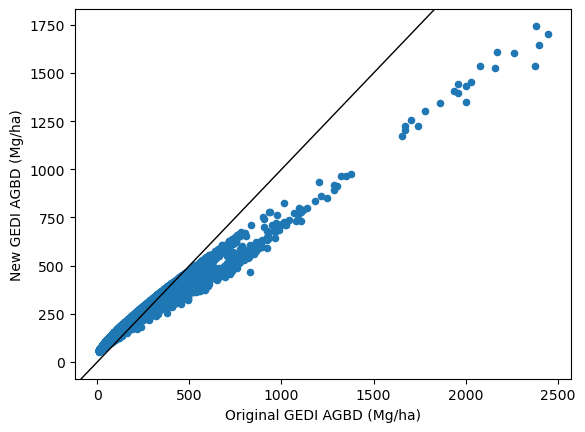

In [46]:
Improved_GEDI_gdf.plot(kind = 'scatter', x = 'agbd', y = 'AGBD_1', xlabel="Original GEDI AGBD (Mg/ha)", ylabel="New GEDI AGBD (Mg/ha)")
plt.axline((0, 0), (1, 1), linewidth=1, color='black')

Note that the new preliminary model typically predicts higher AGBD at the low end, and lower at the high end compared to the original model.

## Part 2: Compare multiple biomass maps (GEDI, CCI) and Cambodian Field Data


**Adding NFI Data**

In this first section we visualize Cambodia's National Forest Inventory(NFI) data over Mondulkiri Srepok National Park.

In [2]:
##Define NFI file path
path = "/projects/shared-buckets/nehajo88/Data/NASA_CMS_2023/CAMBODIA/KHM_AGBD.gpkg"

In [3]:
#Read file using geopandas and pyogrio
NFI_gdf = gpd.read_file(path, engine="pyogrio")

In [4]:
#Create a scatter plot layer from a GeoPandas DataFrame (NFI_gdf) and adds it to a map
NFI_layer = ScatterplotLayer.from_geopandas(NFI_gdf)
m = Map(layers=[NFI_layer])

/opt/conda/lib/python3.10/site-packages/lonboard/_geoarrow/ops/reproject.py:97: UserWarning: Input being reprojected to EPSG:4326 CRS
  warnings.warn("Input being reprojected to EPSG:4326 CRS")


In [5]:
##Sets the fill color of the GEDI_original_layer scatter plot to a specific RGB color value [200, 100, 100].
NFI_layer.get_fill_color = [200, 100, 100]

In [6]:
#Prints the file head for seeing column names which will be needed in next step
NFI_gdf.head()

,X1..Cluster.Number,X_CEN,Y_CEN,AGBD_Kg_Cluster,AGBD.PLOT,geometry
0,95293,X,Y,8544.866404,18.988592,POINT (729338.000 1471740.000)
1,95305,X,Y,0.000000,0.000000,POINT (741338.500 1471790.500)
2,95311,X,Y,1870.999682,4.157777,POINT (747340.000 1471741.000)
3,95317,X,Y,24234.573531,53.854608,POINT (753337.000 1471741.000)
4,95329,X,Y,9496.647798,21.103662,POINT (765337.000 1471741.000)


In [7]:
#Display the map
m= Map(layers=[NFI_layer])
m

Map(layers=[ScatterplotLayer(get_fill_color=[200, 100, 100], table=pyarrow.Table
X1..Cluster.Number: uint32
X_…

Now, we would like to plot data based on a statistic. Let's plot based on the value of the 'AGBD.PLOT' column. We will use a linear colormap excluding the lowest and highest 10 percentiles of the data.

First, we'll find what the values of the 10th and 90th percentile are:

In [8]:
#Calculate the 10th percentile (q10) and the 90th percentile (q90) of the 'agbd' column in the gedi_gdf GeoPandas DataFrame.
q10 = NFI_gdf['AGBD.PLOT'].quantile(.1)
q90 = NFI_gdf['AGBD.PLOT'].quantile(.9)

Then we can construct a "normalizer" based on Normalize that will do linear rescaling between the two values we supply:

In [9]:
normalizer = mpl.colors.Normalize(q10, q90)

Calling this normalizer on our data will return a scaled version ranging between 0 and 1:

In [10]:
normalized_agbd = normalizer(NFI_gdf['AGBD.PLOT'])
normalized_agbd

masked_array(data=[1.06805102e-01, 0.00000000e+00, 2.33862418e-02,
                   3.02915923e-01, 1.18701731e-01, 9.21886933e-02,
                   0.00000000e+00, 4.89534950e-02, 8.41044797e-01,
                   5.48547557e-01, 2.25573421e-01, 2.10265112e-01,
                   4.59945844e-02, 1.11440742e-01, 1.16798183e-03,
                   3.15464584e+00, 7.58921943e-01, 6.98165067e-03,
                   2.99925464e-01, 2.95204391e-01, 1.67591965e-01,
                   0.00000000e+00, 0.00000000e+00, 4.06929019e-01,
                   1.45924167e-02, 9.14915726e-02, 5.87015606e-01,
                   1.03598782e+00, 5.10558737e-01, 0.00000000e+00,
                   1.29452236e-01, 7.44905237e-02, 5.66428009e-01,
                   5.11196919e-01, 1.77135935e-01, 2.66022486e-01,
                   4.31812977e+00, 0.00000000e+00, 5.87069417e-01,
                   5.38203124e+00, 9.84949269e-01, 4.27302503e-01,
                   3.56465597e-01, 5.12055663e+00, 0.00000000e

Here we construct color values by taking a Matplotlib colormap and calling it on our normalized values. Ensure you use bytes=True when calling the colormap object so that the output colors range from 0-255 and not 0-1.

In [11]:
# Ensure lengths match
if len(normalized_agbd) == len(NFI_gdf):
    # Apply the viridis colormap
    viridis_colormap = plt.get_cmap("viridis")
    colors = viridis_colormap(normalized_agbd, bytes=True)
    NFI_layer.get_fill_color = colors
    NFI_layer.radius_min_pixels = 5
else:
    raise ValueError("normalized_agbd length does not match the length of Improved_gedi_gdf")

The map should now have updated to show points colored by their agbd value. To remind ourselves what the high and low values are, we can inspect the colormap object itself:

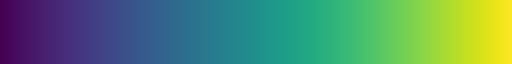

In [12]:
viridis_colormap

For showing the plots against a basemap, here we call upon a basemap from ESRI which can be used on lonboard visualization of the plots.

In [14]:
ESRI_basemap = BitmapTileLayer(
    data="https://services.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}",
    tile_size=256,
    max_requests=-1,
    min_zoom=0,
    max_zoom=19,
)
m = Map(ESRI_basemap)

In [15]:
m = Map([ESRI_basemap,NFI_layer])
m

Map(layers=[BitmapTileLayer(data='https://services.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServ…

**CCI Biomass Layer**

The ESA's Climate Change Initiative (CCI) Biomass project aimed to produce global maps of above-ground biomass for 2010, 2017, and 2018 to quantify biomass changes. The mapping is done with a 100-meter grid spacing, aiming for a relative error of less than 20 percent in areas where the above-ground biomass (AGB) exceeds 50 Mg ha-1. 

For visualizing the CCI Biomass layer, we will use BitmapTileLayer which renders tiles dynamically generated by TiTiler.

In [50]:
titiler_endpoint = "https://titiler.maap-project.org"

In [51]:
CCI_product_url = "s3://maap-ops-workspace/shared/pbasak/Cambodia_Notebook/CCI_AOImasked.tif"

In [52]:
CCI_product_tile_url = "https://titiler.maap-project.org/cog/tiles/{z}/{x}/{y}?url=s3://maap-ops-workspace/shared/pbasak/Cambodia_Notebook/CCI_AOImasked.tif&rescale=0,60&colormap_name=viridis"

In [53]:
r_CCI = httpx.get(
    f"{titiler_endpoint}/cog/info",
    params = {
        "url": CCI_product_url,
    }
).json()

bounds_CCI = r_CCI["bounds"]
print(bounds_CCI)

[106.98488888881904, 12.66844444451776, 107.6088888888128, 13.36711111117744]


In [54]:
CCI_product_layer = BitmapTileLayer(
    data=CCI_product_tile_url,
    tile_size=148,
    max_requests=-1,
    extent=bounds_CCI
)

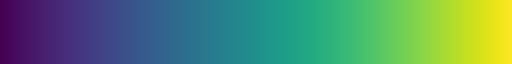

In [55]:
viridis_colormap

In [57]:
m1 = Map([ESRI_basemap, CCI_product_layer, Improved_GEDI_layer, NFI_layer])
m1

Map(layers=[BitmapTileLayer(data='https://services.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServ…